In [1]:
import pandas as pd
from lib.trees import get_tree, parse_edge_list, to_torch
from lib.training import TrainingLoop
from lib.training.callbacks import EarlyStopping, ReduceLROnPlateau
from lib.training.losses import WeightedCrossEntropy
from lib.dataset import split_training_validation
import random
from torch_geometric.nn import GraphSAGE
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import networkx as nx
import torch

2025-05-04 00:58:52.250171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746313132.264536  246609 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746313132.269304  246609 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746313132.279363  246609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746313132.279379  246609 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746313132.279380  246609 computation_placer.cc:177] computation placer alr

In [2]:
sentences = pd.read_csv("../data/train.csv")
sentences["language"] = sentences["language"].astype("category")
sentences["edgelist"] = sentences["edgelist"].apply(parse_edge_list)
sentences["tree"] = sentences["edgelist"].apply(get_tree)
sentences.head()

,language,sentence,n,edgelist,root,tree
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10,"(6, 4, 2, 23, 20, 15, 3, 5, 14, 8, 12, 9, 18, ..."
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10,"(8, 9, 14, 4, 5, 1, 2, 6, 17, 12, 3, 7, 11, 16..."
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3,"(2, 10, 14, 4, 16, 6, 12, 32, 26, 3, 29, 27, 2..."
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30,"(30, 1, 14, 24, 21, 3, 7, 12, 27, 16, 8, 5, 26..."
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11,"(19, 13, 16, 2, 4, 10, 15, 5, 14, 12, 3, 1, 8,..."


In [4]:
random.seed(42)
training, validation = split_training_validation(sentences, 0.2)

print("Training set size:", len(training))
print("Validation set size:", len(validation))

Training set size: 8400
Validation set size: 2100


Let's experiment with adding no features to the nodes or the edges, and just letting the model learn the structure of the graph.

In [5]:
def get_node_labels(row: pd.Series):
    return {n: [float(n == row["root"]), float(n != row["root"])] for n in row["tree"].nodes()}


def get_node_features(row: pd.Series):
    tree = row["tree"]
    degree_centrality = nx.degree_centrality(tree)
    harmonic_centrality = nx.harmonic_centrality(tree)
    betweenness_centrality = nx.betweenness_centrality(tree)
    pagerank = nx.pagerank(tree)

    return {
        n: [degree_centrality[n], harmonic_centrality[n], betweenness_centrality[n], pagerank[n]] for n in tree.nodes()
    }


trees = training.apply(
    lambda r: to_torch(r["tree"], node_features=get_node_features(r), node_labels=get_node_labels(r)), axis=1
).tolist()
train_dataset = DataLoader(trees, batch_size=32, shuffle=True)
# DataLoader groups sub-graphs into mini-batches. See https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html
# for more details. Basically, it combines the smaller graphs into a single large
# disconnected graph without padding, using smart indexing and concatenation
# techniques.

validation_trees = validation.apply(
    lambda r: to_torch(r["tree"], node_features=get_node_features(r), node_labels=get_node_labels(r)), axis=1
).tolist()
validation_dataset = DataLoader(validation_trees, batch_size=32, shuffle=False)

In [6]:
torch.manual_seed(42)
model = GraphSAGE(in_channels=trees[0].x.shape[1], hidden_channels=16, out_channels=2, num_layers=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
class_weights = {0: 1.0, 1: 0.1}

TrainingLoop(
    model=model,
    optimizer=optimizer,
    loss_fn=WeightedCrossEntropy(class_weights),
    train_loader=train_dataset,
    val_loader=validation_dataset,
    epochs=100,
    callbacks=[EarlyStopping(patience=10), ReduceLROnPlateau(factor=0.5, patience=5)],
).train()

Epoch 1/100: loss=2179.50025 val_loss=2192.47655 lr_1=0.01000


Epoch 2/100: loss=2164.84339 val_loss=2190.94559 lr_1=0.01000


Epoch 3/100: loss=2163.83052 val_loss=2190.07726 lr_1=0.01000


Epoch 4/100: loss=2163.75315 val_loss=2190.78491 lr_1=0.01000


Epoch 5/100: loss=2163.68785 val_loss=2189.73493 lr_1=0.01000


Epoch 6/100: loss=2163.72104 val_loss=2189.78700 lr_1=0.01000


Epoch 7/100: loss=2163.58173 val_loss=2189.69312 lr_1=0.01000


Epoch 8/100: loss=2163.68515 val_loss=2189.73802 lr_1=0.01000


Epoch 9/100: loss=2163.51988 val_loss=2189.69414 lr_1=0.01000


Epoch 10/100: loss=2163.43296 val_loss=2190.03114 lr_1=0.01000


Epoch 11/100: loss=2163.58689 val_loss=2192.18777 lr_1=0.01000


Epoch 12/100: loss=2163.42674 val_loss=2189.57334 lr_1=0.01000


Epoch 13/100: loss=2163.30268 val_loss=2190.00630 lr_1=0.01000


Epoch 14/100: loss=2163.42472 val_loss=2190.09990 lr_1=0.01000


Epoch 15/100: loss=2163.75781 val_loss=2190.33977 lr_1=0.01000


Epoch 16/100: loss=2163.48876 val_loss=2189.67577 lr_1=0.01000


Reducing learning rate by a factor of 0.5.
Epoch 17/100: loss=2163.48403 val_loss=2189.78728 lr_1=0.01000


Epoch 18/100: loss=2163.07131 val_loss=2190.09402 lr_1=0.00500


Epoch 19/100: loss=2163.03921 val_loss=2189.61799 lr_1=0.00500


Epoch 20/100: loss=2163.13964 val_loss=2189.93205 lr_1=0.00500


Epoch 21/100: loss=2162.83543 val_loss=2189.46975 lr_1=0.00500


Epoch 22/100: loss=2163.03956 val_loss=2189.64996 lr_1=0.00500


Epoch 23/100: loss=2162.75577 val_loss=2189.94309 lr_1=0.00500


Epoch 24/100: loss=2162.97706 val_loss=2189.50241 lr_1=0.00500


Epoch 25/100: loss=2162.90621 val_loss=2189.40198 lr_1=0.00500


Epoch 26/100: loss=2162.83903 val_loss=2189.48209 lr_1=0.00500


Epoch 27/100: loss=2162.73398 val_loss=2189.53061 lr_1=0.00500


Epoch 28/100: loss=2162.73388 val_loss=2189.88308 lr_1=0.00500


Epoch 29/100: loss=2162.88054 val_loss=2189.24635 lr_1=0.00500


Epoch 30/100: loss=2163.19314 val_loss=2189.63759 lr_1=0.00500


Epoch 31/100: loss=2162.77964 val_loss=2189.45081 lr_1=0.00500


Epoch 32/100: loss=2162.91944 val_loss=2189.37255 lr_1=0.00500


Epoch 33/100: loss=2162.89469 val_loss=2189.58682 lr_1=0.00500


Reducing learning rate by a factor of 0.5.
Epoch 34/100: loss=2162.71031 val_loss=2189.52837 lr_1=0.00500


Epoch 35/100: loss=2162.51524 val_loss=2189.16654 lr_1=0.00250


Epoch 36/100: loss=2162.68529 val_loss=2189.44692 lr_1=0.00250


Epoch 37/100: loss=2162.49449 val_loss=2189.31796 lr_1=0.00250


Epoch 38/100: loss=2162.44943 val_loss=2189.39007 lr_1=0.00250


Epoch 39/100: loss=2162.36342 val_loss=2189.39084 lr_1=0.00250


Reducing learning rate by a factor of 0.5.
Epoch 40/100: loss=2162.40610 val_loss=2189.43158 lr_1=0.00250


Epoch 41/100: loss=2162.46271 val_loss=2189.34651 lr_1=0.00125


Epoch 42/100: loss=2162.32349 val_loss=2189.27038 lr_1=0.00125


Epoch 43/100: loss=2162.37233 val_loss=2189.26574 lr_1=0.00125


Epoch 44/100: loss=2162.38428 val_loss=2189.31083 lr_1=0.00125


                                                                                                    41.39709]

Early stopping triggered after 10 epochs without improvement.
Reducing learning rate by a factor of 0.5.
Epoch 45/100: loss=2162.37072 val_loss=2189.27190 lr_1=0.00125


Node-Based Accuracy: 94.70%
Sentence-Based Accuracy: 28.86%


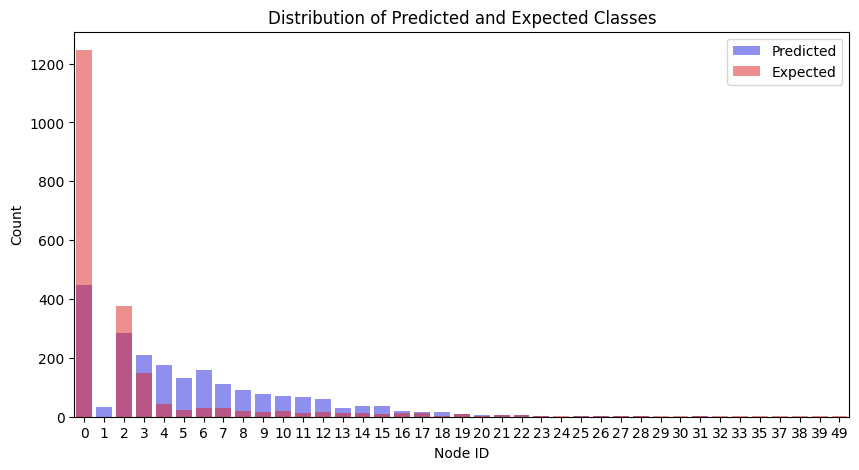

In [7]:
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns


model.eval()
pred_counts = defaultdict(int)
exp_counts = defaultdict(int)
with torch.no_grad():
    correct_nodes = 0
    correct_sentences = 0
    total_nodes = 0
    total_sentences = len(validation_trees)
    for tree in tqdm(validation_trees, leave=False):
        out = model(tree.x, tree.edge_index)
        predicted_classes = torch.argmax(out, dim=1)
        expected_classes = torch.argmax(tree.y, dim=1)
        predicted_root = torch.argmax(out, dim=0)[0].item()
        expected_root = torch.argmax(tree.y, dim=0)[0].item()
        pred_counts[predicted_root] += 1
        exp_counts[expected_root] += 1
        correct_nodes += (expected_classes == predicted_classes).sum().item()
        correct_sentences += predicted_root == expected_root
        total_nodes += len(expected_classes)

    print(f"Node-Based Accuracy: {correct_nodes/total_nodes*100:.2f}%")
    print(f"Sentence-Based Accuracy: {correct_sentences/total_sentences*100:.2f}%")

# Plot the distribution of predicted and expected classes
pred_counts = dict(pred_counts)
exp_counts = dict(exp_counts)
X = sorted(set(pred_counts.keys()) | set(exp_counts.keys()))
pred_counts = [pred_counts.get(x, 0) for x in X]
exp_counts = [exp_counts.get(x, 0) for x in X]
plt.figure(figsize=(10, 5))
sns.barplot(x=X, y=pred_counts, color="blue", label="Predicted", alpha=0.5)
sns.barplot(x=X, y=exp_counts, color="red", label="Expected", alpha=0.5)
plt.xlabel("Node ID")
plt.ylabel("Count")
plt.title("Distribution of Predicted and Expected Classes")
plt.legend()
plt.show()

Let's predict the root of the test dataset, and see how well this model does.

In [8]:
test_sentences = pd.read_csv("../data/test.csv")
test_sentences["language"] = test_sentences["language"].astype("category")
test_sentences["edgelist"] = test_sentences["edgelist"].apply(parse_edge_list)
test_sentences["tree"] = test_sentences["edgelist"].apply(get_tree)
test_sentences.head()

,id,language,sentence,n,edgelist,tree
0,1,Japanese,1,43,"[(38, 33), (10, 38), (24, 16), (30, 24), (32, ...","(38, 33, 10, 24, 16, 30, 32, 9, 15, 28, 37, 19..."
1,2,Japanese,3,49,"[(17, 19), (49, 9), (28, 49), (20, 28), (27, 2...","(17, 19, 49, 9, 28, 20, 27, 14, 47, 4, 33, 12,..."
2,3,Japanese,4,38,"[(15, 38), (10, 4), (20, 10), (25, 20), (15, 2...","(15, 38, 10, 4, 20, 25, 7, 12, 8, 19, 2, 24, 3..."
3,4,Japanese,6,19,"[(6, 9), (18, 6), (3, 4), (18, 3), (3, 2), (10...","(6, 9, 18, 3, 4, 2, 10, 11, 5, 7, 8, 13, 15, 1..."
4,5,Japanese,7,12,"[(3, 8), (7, 11), (3, 7), (3, 12), (3, 5), (1,...","(3, 8, 7, 11, 12, 5, 1, 6, 4, 10, 9, 2)"


In [9]:
test_sentences["torch_tree"] = test_sentences.apply(
    lambda r: to_torch(r["tree"], node_features=get_node_features(r)), axis=1
)
test_sentences.head()

,id,language,sentence,n,edgelist,tree,torch_tree
0,1,Japanese,1,43,"[(38, 33), (10, 38), (24, 16), (30, 24), (32, ...","(38, 33, 10, 24, 16, 30, 32, 9, 15, 28, 37, 19...","[(x, [tensor([0.0476, 8.9539, 0.0476, 0.0246])..."
1,2,Japanese,3,49,"[(17, 19), (49, 9), (28, 49), (20, 28), (27, 2...","(17, 19, 49, 9, 28, 20, 27, 14, 47, 4, 33, 12,...","[(x, [tensor([0.0625, 9.9951, 0.0824, 0.0316])..."
2,3,Japanese,4,38,"[(15, 38), (10, 4), (20, 10), (25, 20), (15, 2...","(15, 38, 10, 4, 20, 25, 7, 12, 8, 19, 2, 24, 3...","[(x, [tensor([ 0.0811, 10.0754, 0.2462, 0.03..."
3,4,Japanese,6,19,"[(6, 9), (18, 6), (3, 4), (18, 3), (3, 2), (10...","(6, 9, 18, 3, 4, 2, 10, 11, 5, 7, 8, 13, 15, 1...","[(x, [tensor([0.1111, 5.8365, 0.1111, 0.0573])..."
4,5,Japanese,7,12,"[(3, 8), (7, 11), (3, 7), (3, 12), (3, 5), (1,...","(3, 8, 7, 11, 12, 5, 1, 6, 4, 10, 9, 2)","[(x, [tensor([0.4545, 7.1667, 0.7091, 0.2109])..."


In [10]:
def get_root(row: pd.Series):
    out = model(row["torch_tree"].x, row["torch_tree"].edge_index)
    predicted_index: int = torch.argmax(out, dim=0)[0].item()
    # get the node number from the nx tree
    node = list(row["tree"].nodes())[predicted_index]
    return node


with torch.no_grad():
    test_sentences["root"] = test_sentences.apply(get_root, axis=1)

test_sentences.head()

,id,language,sentence,n,edgelist,tree,torch_tree,root
0,1,Japanese,1,43,"[(38, 33), (10, 38), (24, 16), (30, 24), (32, ...","(38, 33, 10, 24, 16, 30, 32, 9, 15, 28, 37, 19...","[(x, [tensor([0.0476, 8.9539, 0.0476, 0.0246])...",37
1,2,Japanese,3,49,"[(17, 19), (49, 9), (28, 49), (20, 28), (27, 2...","(17, 19, 49, 9, 28, 20, 27, 14, 47, 4, 33, 12,...","[(x, [tensor([0.0625, 9.9951, 0.0824, 0.0316])...",46
2,3,Japanese,4,38,"[(15, 38), (10, 4), (20, 10), (25, 20), (15, 2...","(15, 38, 10, 4, 20, 25, 7, 12, 8, 19, 2, 24, 3...","[(x, [tensor([ 0.0811, 10.0754, 0.2462, 0.03...",2
3,4,Japanese,6,19,"[(6, 9), (18, 6), (3, 4), (18, 3), (3, 2), (10...","(6, 9, 18, 3, 4, 2, 10, 11, 5, 7, 8, 13, 15, 1...","[(x, [tensor([0.1111, 5.8365, 0.1111, 0.0573])...",11
4,5,Japanese,7,12,"[(3, 8), (7, 11), (3, 7), (3, 12), (3, 5), (1,...","(3, 8, 7, 11, 12, 5, 1, 6, 4, 10, 9, 2)","[(x, [tensor([0.4545, 7.1667, 0.7091, 0.2109])...",6


In [11]:
test_sentences[["id", "root"]].to_csv("../data/submissions/submission-graph-sage-01.csv", index=False)